In [105]:
import pandas as pd
import tweepy
import requests
import numpy as np
import json


In [106]:
df_main = pd.read_csv('twitter-archive-enhanced.csv')
df_main.info()
df_main[['text','rating_numerator']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,text,rating_numerator
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13
6,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,13
7,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,13
8,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,13
9,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,14


## Quality Issues in the first dataframe

- a lot of dogs don't have an age category (floofer,doggo,pupper,puppo)
- 59 missing expanded urls
- (+0000) in the timestamp
- source column has many unneeded text like link to download the platform, we only need the source like (iPhone)
- retweeted user_id and retweeted status_id types are inconvenient (float64, should be int64 or strings) and are not needed as our concern are the main tweets
- in_reply_to_status_id and in_reply_to_user_id types are inconvenient (float64, should be int64 or strings)
- expanded url column has duplicated links
- numerator rating for index 2335 is wrong
- at some indices, the tweet has (>) sign, and in the text it is converted to ('&gt ;')
- some tweets have (\n) in their text, which make it hard to extract information with, so we will replace it with space
- tweets with indices (342,516,1663) doesn't contain a rating, but misplaced because they have slashes and integers like (24/7), etc...
- timestamp data type should be datetime
- dropping the tweets with no expanded urls (No image)

## Tidiness Issues in the first dataframe

- the dog type should be one column including 1 of 4 categories (puppo,pupper,floofer or doggo)


In [107]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url,allow_redirects=True)


In [108]:
Data = r.content
with open('image_predictions.tsv','wb') as f:
    f.write(Data)
df_predictions = pd.read_csv('image_predictions.tsv',sep = '\t')
df_predictions.info()
df_predictions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


## Quality Issues in the second dataframe
- Predictions are not always right, so we need to take the rows with $1^{st}$ prediction p1_dog = True, and p1_conf is high enough 

## Tidiniess Issues in the second dataframe
- We should merge the dog breed with the first dataframe based on the id

## Getting the third dataset from tweeter API

> The following Cell has the code needed to extract it commented, and the tokens removed

In [109]:
#consumer_key = ''
#consumer_secret = ''
#access_token = ''
#access_secret = ''

#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth,wait_on_rate_limit= True , wait_on_rate_limit_notify = True)


#with open('tweet_json.txt','w') as file:
#    for id in df_main['tweet_id']:
#        try:
#            tweet = api.get_status(id,tweet_mode = 'extended')
#            json.dump(tweet._json,file)
#            file.write("\n")
#           print(id)
#        except:
#            print("rejected: {}".format(id))
#print('finished')


In [110]:
with open('tweet_json.txt') as f:
    content = f.readlines() #Get a list of each line (json file)

df_tweet = pd.DataFrame() #Make the main dataset
for item in content: #Iterate on each json file
    x = json.loads(item) #Load the string dict to dict
    remove_keys = [] #Keys that has unecessary complex values inside it
    for key in x.keys():
        if (type(x[key]) is dict):
            remove_keys.append(key)
    for item in remove_keys:
        x.pop(item)
    temp = pd.DataFrame.from_dict(x) #Get the dataframe from the dict
    df_tweet = df_tweet.append(temp,ignore_index=True) #Append it to our dataframe
#Testing
df_tweet.head()

,contributors,coordinates,created_at,display_text_range,favorite_count,favorited,full_text,geo,id,id_str,...,lang,place,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,source,truncated
0,None,None,Tue Aug 01 16:23:56 +0000 2017,0,38422,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,892420643555336193,892420643555336193,...,en,None,False,False,NaN,NaN,8439,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False
1,None,None,Tue Aug 01 16:23:56 +0000 2017,85,38422,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,892420643555336193,892420643555336193,...,en,None,False,False,NaN,NaN,8439,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False
2,None,None,Tue Aug 01 00:17:27 +0000 2017,0,32900,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",None,892177421306343426,892177421306343426,...,en,None,False,False,NaN,NaN,6221,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False
3,None,None,Tue Aug 01 00:17:27 +0000 2017,138,32900,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",None,892177421306343426,892177421306343426,...,en,None,False,False,NaN,NaN,6221,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False
4,None,None,Mon Jul 31 00:18:03 +0000 2017,0,24792,False,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,None,891815181378084864,891815181378084864,...,en,None,False,False,NaN,NaN,4119,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False


In [111]:
#Taking the only columns we are intersted in from the third dataset
df_tweet = df_tweet[['favorite_count','id','retweet_count']] #Taking only the needed columns
df_tweet = df_tweet.drop_duplicates() #Dropping the duplicated rows
df_tweet.index = range(len(df_tweet['id'])) #reindexing
#Testing
df_tweet

,favorite_count,id,retweet_count
0,38422,892420643555336193,8439
1,32900,892177421306343426,6221
2,24792,891815181378084864,4119
3,41747,891689557279858688,8567
4,39908,891327558926688256,9298
5,20032,891087950875897856,3085
6,11725,890971913173991426,2050
7,64846,890729181411237888,18724
8,27552,890609185150312448,4227
9,31608,890240255349198849,7334


## Issues with third dataset

> This dataset is clean, it will only be merged to the dataset we produce in the final stage after cleaning the first two sets

- Cleaning retweet columns by removing them

In [112]:
pd.set_option('display.max_colwidth', -1)
df_main = df_main.drop(['retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp'],axis = 1)
#Testing
df_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying in

- Cut the +0000 in the timestampe
- Changing its data type

In [113]:
#Cleaning the first dataframe time stamp column
def cut_text(row):
    return row['timestamp'][:-5] #Remove the last 5 characters
df_main['timestamp'] = df_main.apply(cut_text,axis=1)
df_main['timestamp'] = pd.to_datetime(df_main['timestamp']) #Change to datetime type
#Testing
df_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so e

- Cleaning Source column from the url

In [114]:
#Cleaning Source Column
def extract_source(row):
    return row['source'].split('>')[1][:-3] #Split the source with (>) and choose the second slice without the last 3 characters
df_main['source'] = df_main.apply(extract_source,axis=1)
#Testing
df_main['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

- Cleaning the reply columns by changing its type

In [115]:
#Cleaning In_reply_status_id and In_reply_user_id columns by changing the data type to int64
df_main['in_reply_to_status_id'] = df_main['in_reply_to_status_id'].replace(np.nan,-1) #Replace each nan with -1
df_main['in_reply_to_user_id'] = df_main['in_reply_to_user_id'].replace(np.nan,-1) 
df_main['in_reply_to_status_id'] = df_main['in_reply_to_status_id'].astype('int64') #Change into int
df_main['in_reply_to_user_id'] = df_main['in_reply_to_user_id'].astype('int64')
df_main['in_reply_to_status_id'] = df_main['in_reply_to_status_id'].astype('str') #Change into str
df_main['in_reply_to_user_id'] = df_main['in_reply_to_user_id'].astype('str')
df_main['in_reply_to_status_id'] = df_main['in_reply_to_status_id'].replace('-1','NaN') #Change the -1 into NaN again
df_main['in_reply_to_user_id'] = df_main['in_reply_to_user_id'].replace('-1','NaN')
#Testing
df_main[df_main['in_reply_to_user_id'] != 'NaN']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,886266357075128320,2281181600,2017-07-15 16:51:35,Twitter for iPhone,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,12,10,None,None,None,None,None
55,881633300179243008,881607037314052096,47384430,2017-07-02 21:58:53,Twitter for iPhone,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,17,10,None,None,None,None,None
64,879674319642796034,879553827334172672,3105440746,2017-06-27 12:14:36,Twitter for iPhone,@RealKentMurphy 14/10 confirmed,NaN,14,10,None,None,None,None,None
113,870726314365509632,870726202742493184,16487760,2017-06-02 19:38:25,Twitter for iPhone,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,10,10,None,None,None,None,None
148,863427515083354112,863425645568774144,77596200,2017-05-13 16:15:35,Twitter for iPhone,"@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,12,10,None,None,None,None,None
149,863079547188785154,667152164079423488,4196983835,2017-05-12 17:12:53,Twitter for iPhone,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None
179,857214891891077121,857156678055342080,180670967,2017-04-26 12:48:51,Twitter for iPhone,@Marc_IRL pixelated af 12/10,NaN,12,10,None,None,None,None,None
184,856526610513747968,855818117272018944,4196983835,2017-04-24 15:13:52,Twitter for iPhone,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
186,856288084350160898,856286004109553664,279280991,2017-04-23 23:26:03,Twitter for iPhone,@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,14,10,None,None,None,None,None
188,855862651834028034,855861584463351808,194351775,2017-04-22 19:15:32,Twitter for iPhone,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,420,10,None,None,None,None,None


- Cleaning the expanded_urls duplications
- dropping the tweets with no expanded urls (No image)

In [116]:
#Cleaning Expanded_urls duplications
def remove_duplicates(row):
    unique = []
    if(row['expanded_urls'] == 'nan'):
        return row['expanded_urls']
    else:
        data = row['expanded_urls'].split(',')
        unique.append(data[0])
        if (len(data) > 1):
            for i in range(len(data)): #Check if there is more than one link
                if(data[i] not in unique): #Only take more than one link if they are not duplicates
                    unique.append(data[i]) #Add it to the unique urls
            return ','.join(unique) #Return the uniqure urls separated with comma
        else:
            return ''.join(data) #Return the single url returned
to_remove = df_main[df_main['expanded_urls'] == 'nan'] #Rows with nan
df_main = df_main.drop(to_remove.index) #Remove nan rows
df_main['expanded_urls'] = df_main['expanded_urls'].astype('str')       
df_main['expanded_urls'] = df_main.apply(remove_duplicates,axis=1)
#Testing
df_main.expanded_urls.unique()

array(['https://twitter.com/dog_rates/status/892420643555336193/photo/1',
       'https://twitter.com/dog_rates/status/892177421306343426/photo/1',
       'https://twitter.com/dog_rates/status/891815181378084864/photo/1',
       ...,
       'https://twitter.com/dog_rates/status/666033412701032449/photo/1',
       'https://twitter.com/dog_rates/status/666029285002620928/photo/1',
       'https://twitter.com/dog_rates/status/666020888022790149/photo/1'], dtype=object)

- Fixing the greater than sign and testing on index 113

In [117]:
#Cleaning the tweet text of tweets having greater than sign
def greater_transform(row):    
    row['text'] = row['text'].replace('&gt;' , '> ') #Replace greater than Sign issued with the real greater than followed by a space
    return row['text']
df_main['text'] = df_main.apply(greater_transform,axis=1)
#Testing
df_main['text'][113] #example to see the output

'@ComplicitOwl @ShopWeRateDogs > 10/10 is reserved for dogs'

- Fixing tweet having \n in their text

In [118]:
def newline_transform(row):    
    row['text'] = row['text'].replace('\n',' ') #Replace the newline sign with space
    return row['text']
df_main['text'] = df_main.apply(newline_transform,axis=1)
#Testing
df_main['text'][742] #example to see the output

'RT @Patreon: Well. @dog_rates is on Patreon.   12/10.   https://t.co/rnKvzt6RJs https://t.co/v4e2ywe8iO'

- Remove the tweets that has no rating 

In [119]:
#Cleaning the non rating tweets
df_main = df_main.drop([342,516,1663]) #having slashes and numbers but doesn't have a rating

- Extract the right numerators

In [120]:
def convertable(string): #To check if a string is convertable to int
    try: 
        int(string)
        return True
    except ValueError:
        return False
convertable('(9)') #Check the function

False

In [121]:
#Now, we will clean the numerators to extract the right numerators from the tweet text
def extract_numerator(row):
    x = row['text'].split(':/')
    length = len(x)
    if(length == 1): #No links in the text
        text = x[0] #Because it is pure text without links
    else:
        text = x[0][:-6] #To remove https from it in case it has a link in the text
    parts = text.split('/') #Split to get the numerators and denominator
    length2 = len(parts)
    if length2 == 2: #Only one slash then what before it is the numerator, what after it is the denominator
        if(convertable(parts[1][:3])): #Check for various lengths of both numerator and denominator to assure we get all the number
            row['rating_denominator'] = int(parts[1][:3])
        else: #If the denominator is not 3 digit number, then take only the 2 digits after the slash
            row['rating_denominator'] = int(parts[1][:2])
        if(convertable(parts[0][-4:])): #If the numerator is 4 numbers, take all of them
            row['rating_numerator'] = float(parts[0][-4:])
        elif(convertable(parts[0][-3:])): #If not, try if it is 3 numbers, then take it
            row['rating_numerator'] = float(parts[0][-3:])
        elif(convertable(parts[0][-2:])): #If not, try if it is 2 numbers, then take it
            row['rating_numerator'] = float(parts[0][-2:])
        elif(convertable(parts[0][-1:])): #If not, take the last number before the slash
            row['rating_numerator'] = float(parts[0][-1:])
        return row[['rating_numerator','rating_denominator']]
    else: #there is more than one slash
        i = length2-1
        while(i > 0): #Search for the last denominator if it is a multiple of 10, because probably this will be the real rating except if it has no blanks before it
            if(int(parts[i][:2]) % 10 == 0 and int(parts[i][:2]) != 0 and parts[i][1] != ' ' ):#must check if the number is divisible by 10, and doesn't equal to 0, also the second slot is not blank
                row['rating_denominator'] = int(parts[i][:2])
                if len(parts[i-1]) > 3 :
                    if ('.' in parts[i-1][-3:] and ' ' not in parts[i-1][-4:]): #in case we have a float numerator like 3.5
                        index = parts[i-1].index(' ',-6) #Searching for the blank before the number, to get the number exactly
                    else :
                        if(' ' in parts[i-1][-4:]): #Searching for the blank but in smaller range since there is no floating point
                            index = parts[i-1].index(' ',-4)
                            row['rating_numerator'] = float(parts[i-1][index+1:]) #Accessing the number from the index after the blank to the end
                            i = 0
                        else: i -= 1 #if there is no blank, then we are at the wrong slash, get back to the splitted part before
                else: 
                    row['rating_numerator'] = float(parts[i-1]) #This condition means that length of the splitted part only 2 or less, which means the beginning of the part is the number
                    i = 0
            else:
                i -= 1
        return row[['rating_numerator','rating_denominator']]
df_main[['rating_numerator','rating_denominator']] = df_main.apply(extract_numerator,axis=1)
#Testing
df_main['rating_denominator'].value_counts()

10     2340
80     2   
50     2   
170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
Name: rating_denominator, dtype: int64

## Till Now we Resolved
- (+0000) in the timestamp
- source column has many unneeded text like link to download the platform, we only need the source like (iPhone)
- retweeted user_id and retweeted status_id types are inconvenient (float64, should be int64 or strings) and are not needed as our concern are the main tweets
- in_reply_to_status_id and in_reply_to_user_id types are inconvenient (float64, should be int64 or strings)
- expanded url column has duplicated links
- numerator rating for index 2335 is wrong
- at some indices, the tweet has (>) sign, and in the text it is converted to ('&gt ;')
- some tweets have (\n) in their text, which make it hard to extract information with, so we will replace it with space
- tweets with indices (342,516,1663) doesn't contain a rating, but misplaced because they have slashes and integers like (24/7), etc...
- timestamp datatype
- dropping the tweets with no expanded urls (No image)

> Which are 11 quality issues, so we are done with the quality issues for this task, let's address some tidiness

- Convert dog types to one column

In [123]:
def dog_types(row): #Will assume that any unknown dog stage is a floofer
    if(row['doggo'] != 'None'):
        row['Type'] = 'doggo'
    elif(row['pupper'] != 'None'):
        row['Type'] = 'pupper'
    elif(row['puppo'] != 'None' ):
        row['Type'] = 'puppo'
    else: row['Type'] = 'floofer'
    return row['Type']

df_main['Type'] = df_main.apply(dog_types,axis = 1)
df_main.drop(['doggo','pupper','puppo','floofer'],axis=1)
df_main['Type'] = df_main['Type'].astype('category')
#Testing
df_main['Type']

0       floofer
1       floofer
2       floofer
3       floofer
4       floofer
5       floofer
6       floofer
7       floofer
8       floofer
9       doggo  
10      floofer
11      floofer
12      puppo  
13      floofer
14      puppo  
15      floofer
16      floofer
17      floofer
18      floofer
19      floofer
20      floofer
21      floofer
22      floofer
23      floofer
24      floofer
25      floofer
26      floofer
27      floofer
28      floofer
29      pupper 
         ...   
2326    floofer
2327    floofer
2328    floofer
2329    floofer
2330    floofer
2331    floofer
2332    floofer
2333    floofer
2334    floofer
2335    floofer
2336    floofer
2337    floofer
2338    floofer
2339    floofer
2340    floofer
2341    floofer
2342    floofer
2343    floofer
2344    floofer
2345    floofer
2346    floofer
2347    floofer
2348    floofer
2349    floofer
2350    floofer
2351    floofer
2352    floofer
2353    floofer
2354    floofer
2355    floofer
Name: Type, Length: 2353

## Second Dataset

> Now, we will clean the quality issue of the second data set which was
- having only one prediction for the dog breed

In [124]:
df_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


- Dog type extraction from predictions

In [125]:
def dog_type_extraction(row):#Will extract the first prediction if it's dog, if not the second prediction, if not then the third
    if(row['p1_dog']): #If the first prediction is dog, take it
        row['Dog_Breed'] = row['p1']
        return row['Dog_Breed'] 
    elif(row['p2_dog']): #If not, take the second prediction if it is dog
        row['Dog_Breed'] = row['p2']
        return row['Dog_Breed']
    elif(row['p3_dog']): #If not, take the third one if it is dog
        row['Dog_Breed'] = row['p3']
        return row['Dog_Breed']
    else: #If no one of them is dog prediction, then return None
        return None
df_predictions['Dog_Breed'] = df_predictions.apply(dog_type_extraction,axis=1)
df_predictions['Dog_Breed']
#drop the observations with none type, and drop the columns of predictions
df_predictions = df_predictions.dropna(subset=['Dog_Breed'])
df_predictions = df_predictions.drop(['p1','p1_dog','p1_conf','p2','p2_dog','p2_conf','p3','p3_dog','p3_conf'],axis = 1)
#Testing
df_predictions.info() #As we can see, we now have a dataset with suitable dog breed and clean variables

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id     1751 non-null int64
jpg_url      1751 non-null object
img_num      1751 non-null int64
Dog_Breed    1751 non-null object
dtypes: int64(2), object(2)
memory usage: 68.4+ KB


> Now, we solved the quality issue in the second dataset

> So let's address the tidiness issue, and merge both datasets together to give a clean overall dataset

- Merging the 3 datasets

In [126]:
df_merged = df_main
df_merged = df_merged.join(df_predictions,how='inner',lsuffix='_caller', rsuffix='_other')
df_merged = df_merged.drop(['tweet_id_other'],axis = 1)#Drop the second id column


columns = df_merged.columns.values
columns[0] = 'id' #Renaming the id column to fit with the third dataset
df_merged.columns = columns


df_merged = df_merged.join(df_tweet,how='inner',lsuffix='_caller',rsuffix='_other')
df_merged = df_merged.drop(['id_other'],axis = 1)#Drop the second id column
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 0 to 2073
Data columns (total 20 columns):
id_caller                1749 non-null int64
in_reply_to_status_id    1749 non-null object
in_reply_to_user_id      1749 non-null object
timestamp                1749 non-null datetime64[ns]
source                   1749 non-null object
text                     1749 non-null object
expanded_urls            1749 non-null object
rating_numerator         1749 non-null float64
rating_denominator       1749 non-null int64
name                     1749 non-null object
doggo                    1749 non-null object
floofer                  1749 non-null object
pupper                   1749 non-null object
puppo                    1749 non-null object
Type                     1749 non-null category
jpg_url                  1749 non-null object
img_num                  1749 non-null int64
Dog_Breed                1749 non-null object
favorite_count           1749 non-null int64
retweet_coun

## Finishing Cleaning

> So now, we addressed and solved 8+ Quality issues which are:

- (+0000) in the timestamp
- source column has many unneeded text like link to download the platform, we only need the source like (iPhone)
- retweeted user_id and retweeted status_id types are inconvenient (float64, should be int64 or strings) and are not needed as our concern are the main tweets
- in_reply_to_status_id and in_reply_to_user_id types are inconvenient (float64, should be int64 or strings)
- expanded url column has duplicated links
- numerator rating for index 2335 is wrong
- at some indices, the tweet has (>) sign, and in the text it is converted to ('&gt ;')
- some tweets have (\n) in their text, which make it hard to extract information with, so we will replace it with space
- tweets with indices (342,516,1663) doesn't contain a rating, but misplaced because they have slashes and integers like (24/7), etc...
- Second dataset dog predictions
- timestamp data type

> And 2 Tidiness Issues which are:

- Dog Stage columns (Doggo,pupper,puppo,floofer)
- Merging the three datasets

## Storing the dataset

In [127]:
df_merged.to_csv('twitter_archive_master.csv')

## Analyze

In [128]:
#I will extract the needed variables only, and to make the plots real time, i will make the index 'timestamp' variable

time_df = df_merged[['timestamp', 'retweet_count', 'favorite_count', 'rating_numerator', 'rating_denominator','Type']].copy()

time_df.set_index('timestamp', inplace=True)

#Since denominators are not the same, we will divide the numerator by denominator to get the normalized score of rating

time_df['rating_score'] = time_df['rating_numerator']/time_df['rating_denominator']


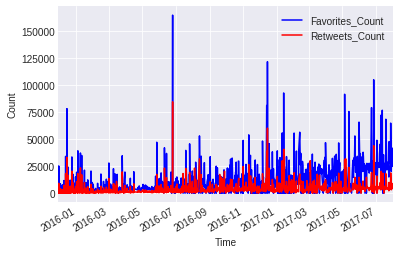

In [129]:
#Plotting the counts of retweets and favorites for their tweets
import matplotlib.pyplot as plt
time_df['favorite_count'].plot(color = 'blue', label='Favorites_Count')
time_df['retweet_count'].plot(color = 'red', label='Retweets_Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()


> Favourite counts are clearly more than retweet counts (Always)

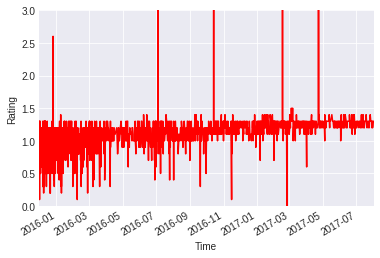

In [130]:
#Plotting the rating time plot
time_df['rating_score'].plot(color='r')
plt.xlabel('Time')
plt.ylabel('Rating')
plt.ylim(0, 3)
plt.show()


> It is clear that rating are increasing over time, at the beginning of 2016 much were from 0 to 1, but as we go further the lower boundary of the rating increase till it react 1 or higher in 05-2017

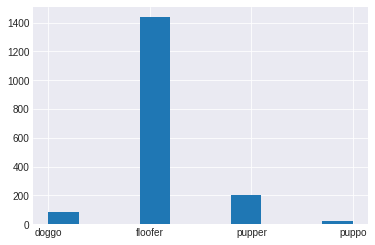

In [131]:
#Plotting the count of dog breeds
time_df['Type'].hist()
plt.show()

> It appears that floofers are the most common type followed by puppers then doggos then puppos